In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as sqlF
from pyspark import SparkContext, SparkConf

from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, NGram
from pyspark.ml import Pipeline, Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import Binarizer

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/pranav/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/pranav/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
conf = SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.driver.memory','5g')]) #controllo RAM

my_spark = SparkSession \
    .builder.master('local[*]') \
    .appName("RegressionApp")\
    .config(conf=conf)\
    .getOrCreate()

sqlContext = SQLContext(my_spark)

In [6]:
path = "hdfs://localhost:9000/TextMining/tokens/part-00000" #change to part-* when executing everything

original_schema = StructType([StructField("product", StringType(), True),
         StructField("votes", IntegerType(), True),
         StructField("rate", DoubleType(), True),
         StructField("text", StringType(), True)])

original_data = sqlContext.read.\
                options(header='false', 
                inferschema='false',
                delimiter="\t").\
                schema(original_schema).csv(path).na.drop()

In [14]:
binarizer = Binarizer()\
  .setInputCol("rate")\
  .setOutputCol("label")\
  .setThreshold(3.5)

# get n-grams
tokenizer = RegexTokenizer()\
  .setInputCol("text")\
  .setOutputCol("tokens")\
  .setPattern("\\W")

ngrams = NGram()\
  .setInputCol(tokenizer.getOutputCol())\
  .setOutputCol("n-grams")

# calc tf-idf 
tf = HashingTF()\
  .setInputCol(ngrams.getOutputCol())\
  .setOutputCol("tf")
idf = IDF()\
  .setInputCol(tf.getOutputCol())\
  .setOutputCol("tf-idf")\
  .setMinDocFreq(3)

# build the classifier
classifierMod = LogisticRegression()\
  .setMaxIter(10)\
  .setFeaturesCol(idf.getOutputCol())\
  .setLabelCol(binarizer.getOutputCol())

# this is the pipeline that data follows to be evaluated
pipeline = Pipeline(stages = [binarizer, tokenizer, ngrams, tf, idf, classifierMod])

In [18]:
# a little of optimization: try different hyperparameters
paramGrid = ParamGridBuilder()\
  .addGrid(classifierMod.regParam, [0.01, 0.05, 0.1])\
  .addGrid(ngrams.n, [1, 2, 3])\
  .build()

# do it with a cross validation on the train set (3 folds)
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(3)

In [19]:
print("Training... ");
model = cv.fit(original_data)
print("done!")

Training... 
done!


In [25]:
model.avgMetrics

[0.8938831428943195,
 0.8438780555556324,
 0.6684015764706526,
 0.9035467454607642,
 0.8638633730425431,
 0.684228390480026,
 0.9053547458336451,
 0.8714815285643673,
 0.6912878978506443]

In [32]:
for i, metrics in enumerate(model.avgMetrics):
    print(model.getEstimatorParamMaps()[i])
    print(metrics)
    print()

{Param(parent='LogisticRegression_063e134a075d', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='NGram_4e3dfc95ea02', name='n', doc='number of elements per n-gram (>=1)'): 1}
0.8938831428943195

{Param(parent='LogisticRegression_063e134a075d', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='NGram_4e3dfc95ea02', name='n', doc='number of elements per n-gram (>=1)'): 2}
0.8438780555556324

{Param(parent='LogisticRegression_063e134a075d', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='NGram_4e3dfc95ea02', name='n', doc='number of elements per n-gram (>=1)'): 3}
0.6684015764706526

{Param(parent='LogisticRegression_063e134a075d', name='regParam', doc='regularization parameter (>= 0).'): 0.05, Param(parent='NGram_4e3dfc95ea02', name='n', doc='number of elements per n-gram (>=1)'): 1}
0.9035467454607642

{Param(parent='LogisticRegression_063e134a075d', name='regParam', doc='regularization parameter (>= 

In [58]:
regParam = [list(x.values())[0] for x in model.getEstimatorParamMaps()]
n_grams = [list(x.values())[1] for x in model.getEstimatorParamMaps()]
score = model.avgMetrics

In [64]:
import numpy as np

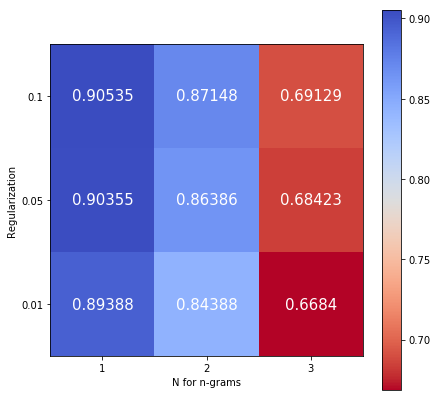

In [91]:
plt.figure(figsize=(7,7))
score_array = np.array(score).reshape(3,3)
plt.imshow(score_array, cmap=plt.cm.coolwarm_r)
plt.xticks([0,1,2], [1,2,3])
plt.yticks([0,1,2],[0.01, 0.05, 0.1])
plt.colorbar()

plt.gca().invert_yaxis()

for i in range(3):
    for j in range(3):
        text = plt.text(j, i, round(score_array[i, j],5),
                       ha="center", va="center", color="w", fontsize=15)
        
plt.xlabel("N for n-grams")
plt.ylabel("Regularization")
        
plt.show()